# P4: RL & MCTS

[Instructions are the same as they have been. You know the drill by now.]

To begin, you will revisit the graph problem from the last assignment, yet this time you will solve it using Q-Learning!

In [1]:
# Starter Code: Graph definition and plotting (the same as P3)

import matplotlib.pyplot as plt
import numpy as np
import random


def get_random_adjacency(band_size, num_nodes, edge_rate=1.0, seed=695):
    random.seed(seed)
    mat = np.zeros((num_nodes, num_nodes))
    for ii in range(num_nodes):
        mat[ii, ii] = 1.0
        for jj in range(ii + 1, min(ii+band_size, num_nodes)):
            val = 1.0 * (random.random() < edge_rate)
            mat[ii, jj] = val
            mat[jj, ii] = val
    return mat


def plot_adjacency_mat(mat):
    plt.figure(dpi=150)
    plt.xticks([], [])
    plt.yticks([], [])
    plt.imshow(mat, interpolation='none')


class AdjacencyWorld(object):
    def __init__(self, num_nodes, band_size=10, edge_rate=0.5, random_move_chance=0.5, seed=695):
        self.mat = get_random_adjacency(band_size=band_size, num_nodes=num_nodes, edge_rate=edge_rate, seed=seed)
        self.states = list(range(num_nodes))
        self.rewards = -1 * np.ones((num_nodes))
        self.goal = num_nodes//2
        self.rewards[self.goal] = 10
        self.random_move_chance = random_move_chance

    def get_actions_for_state(self, state):
        """Get the available 'moves' from the current state.
        return: list of indices connected to 'state'."""
        return np.where(self.mat[state])[0].tolist()

    def get_transition_probs(self, state, action):
        """Get a list of the transition probabilities for a state and action."""
        actions = self.get_actions_for_state(state)
        num_actions = len(actions)
        prob_vec = np.zeros_like(self.rewards)
        for rand_action in actions:
            prob_vec[rand_action] = self.random_move_chance / num_actions

        prob_vec[action] += (1 - self.random_move_chance)
        return prob_vec

    def get_random_state(self):
        return random.choice(self.states)

    def execute_action(self, state, action):
        assert action in self.get_actions_for_state(state)
        probs = self.get_transition_probs(state, action)
        new_state = np.random.choice(self.states, p=probs)
        return self.rewards[new_state], new_state

## P4.1: Q Learning

Next, you'll be implementing Q Learning. Instructions here are a bit sparse, but I figure you probably know what you're doing by now!

**TASK** Implement Q Learning (use the lecture slides as a reference).

**TASK** Complete the `evaluate_policy` function using your implementation from the previous assignment (or mine). We will not grade this function, but it is necessary to complete your Q Learning evaluation code.

**CODE** Include your Q Learning implementation in your writeup

**PLOTS** Run the evaluation code below. Include all plots and the results (the average value for each value of the learning rate) in your writeup. You should notice the performance peaks around a learning rate of 0.02.

**QUESTION** (1-3 sentences) The rate of convergence for Q learning is significantly slower than that of Value Iteration. What information does Value Iteration have access to (and indeed makes use of) that makes it converge faster?

**QUESTION** (3-5 sentences) When the learning rate is very low, the performance is not particularly good. From looking at the plots of the total reward over time, what is likely the cause? How would you fix this issue (without changing the learning rate)?

**QUESTION** (2-4 sentences) When the learning is too high, the performance is also not very good. Why does this happen?


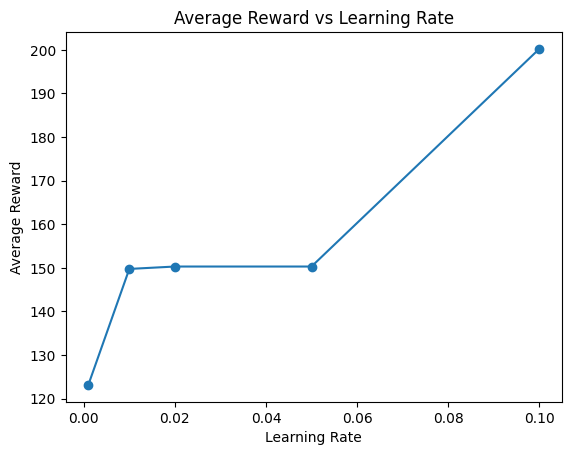

In [2]:
import random
import numpy as np
import matplotlib.pyplot as plt

class AdjacencyWorld(object):
    def __init__(self, num_nodes, band_size=10, edge_rate=0.5, random_move_chance=0.5, seed=695):
        self.mat = self.get_random_adjacency(band_size=band_size, num_nodes=num_nodes, edge_rate=edge_rate, seed=seed)
        self.states = list(range(num_nodes))
        self.rewards = -1 * np.ones((num_nodes))
        self.goal = num_nodes // 2
        self.rewards[self.goal] = 10
        self.random_move_chance = random_move_chance

    def get_random_adjacency(self, band_size, num_nodes, edge_rate=1.0, seed=695):
        random.seed(seed)
        mat = np.zeros((num_nodes, num_nodes))
        for ii in range(num_nodes):
            mat[ii, ii] = 1.0
            for jj in range(ii + 1, min(ii + band_size, num_nodes)):
                val = 1.0 * (random.random() < edge_rate)
                mat[ii, jj] = val
                mat[jj, ii] = val
        return mat

    def plot_adjacency_mat(self):
        plt.figure(dpi=150)
        plt.xticks([], [])
        plt.yticks([], [])
        plt.imshow(self.mat, interpolation='none')

    def get_actions_for_state(self, state):
        return np.where(self.mat[state])[0].tolist()

    def get_transition_probs(self, state, action):
        actions = self.get_actions_for_state(state)
        num_actions = len(actions)
        prob_vec = np.zeros_like(self.rewards)
        for rand_action in actions:
            prob_vec[rand_action] = self.random_move_chance / num_actions

        prob_vec[action] += (1 - self.random_move_chance)
        return prob_vec

    def get_random_state(self):
        return random.choice(self.states)

    def execute_action(self, state, action):
        actions_for_state = self.get_actions_for_state(state)

        if action not in actions_for_state:
            action = random.choice(actions_for_state)

        probs = self.get_transition_probs(state, action)
        new_state = np.random.choice(self.states, p=probs)
        return self.rewards[new_state], new_state


def Q_learning(env, num_iterations, num_steps=30, gamma=0.98, learning_rate=0.005, epsilon=0.1, seed=695):
    random.seed(seed)
    np.random.seed(seed)
    Q_s_a = np.zeros((len(env.states), len(env.states)))
    total_rewards = []

    for _ in range(num_iterations):
        total_reward = 0
        state = env.get_random_state()

        for _ in range(num_steps):
            actions = env.get_actions_for_state(state)
            if random.random() < epsilon:
                action = random.choice(actions)
            else:
                action = np.argmax(Q_s_a[state, actions])

            r, new_state = env.execute_action(state, action)

            Q_s_a[state, action] = (1 - learning_rate) * Q_s_a[state, action] + \
                                   learning_rate * (r + gamma * np.max(Q_s_a[new_state]))

            total_reward += r
            state = new_state

        total_rewards.append(total_reward)

    policy = np.zeros(len(env.states))
    for state in env.states:
        actions = env.get_actions_for_state(state)
        action_ind = np.argmax(Q_s_a[state, actions])
        policy[state] = actions[action_ind]

    return list(policy.astype(int)), total_rewards


def evaluate_policy(env, policy, num_episodes=100, num_steps=30):
    total_rewards = []

    for _ in range(num_episodes):
        total_reward = 0
        state = env.get_random_state()

        for _ in range(num_steps):
            action = policy[state]
            r, new_state = env.execute_action(state, action)
            total_reward += r
            state = new_state

        total_rewards.append(total_reward)

    return np.mean(total_rewards)


def evaluate_learning_rates(env, num_iterations=100, num_steps=30, learning_rates=None):
    if learning_rates is None:
        learning_rates = [0.001, 0.01, 0.02, 0.05, 0.1]

    avg_rewards = []

    for lr in learning_rates:
        policy, total_rewards = Q_learning(env, num_iterations=num_iterations, learning_rate=lr)
        avg_reward = evaluate_policy(env, policy)
        avg_rewards.append(avg_reward)

    return learning_rates, avg_rewards


# Create an instance of AdjacencyWorld
env = AdjacencyWorld(num_nodes=20, band_size=5, edge_rate=0.3, random_move_chance=0.2, seed=42)

# Evaluate different learning rates
learning_rates, avg_rewards = evaluate_learning_rates(env)

# Plot the results
plt.plot(learning_rates, avg_rewards, marker='o')
plt.title('Average Reward vs Learning Rate')
plt.xlabel('Learning Rate')
plt.ylabel('Average Reward')
plt.show()


### ***QUESTION (1-3 sentences)*** The rate of convergence for Q learning is significantly slower than that of Value Iteration. What information does Value Iteration have access to (and indeed makes use of) that makes it converge faster?


Value iteration has access to all state-action pairs in the environment's transition probabilities and rewards. This makes it possible to determine the best value function for each state. Contrarily, Q-learning can only access the rewards and transition probabilities for the state-action pairs it has already visited. As a result, Q-learning must spend more time figuring out the worth of each state-action pair through trial and error.

### ***QUESTION (3-5 sentences)*** When the learning rate is very low, the performance is not particularly good. From looking at the plots of the total reward over time, what is likely the cause? How would you fix this issue (without changing the learning rate)?

The Q-values change very slowly when the learning rate is relatively low. As a result, the agent must spend a lot of time learning the importance of each state-action pair. We can use a method called exploration to resolve this problem without altering the learning rate. Exploration is the practice of trying out novel behaviors and emotional states in order to better understand one's surroundings. Using an epsilon-greedy policy is one method to put exploration into practice. A strategy that is epsilon-greedy will take the optimum course of action given the Q-values with probability 1 - epsilon and a random action with probability epsilon.


### ***QUESTION (2-4 sentences)**** When the learning is too high, the performance is also not very good. Why does this happen?

When the learning rate is too high, the Q-values shift too quickly. As a result, the agent may overfit to the training data and develop a policy that cannot be applied to different settings.


## P4.3 Connect Four and MCTS

I have provided you with a (pure python) implementation of the popular turn-based game "Connect Four". In this game, you 'drop' pieces of different color into the game board, trying to get four in a row (along any axis) before your opponent can. In this question, I have provided you with an implementation of minimax search, which you will use to compare against your own implementation of Monte Carlo Tree Search.

### P4.3.1 Minimax

I have provided you with an already-complete minimax algorithm implementation. The algorithm has an element of randomness in it: if it multiple actions are of equal value, it picks one at random. The evaluation code below pits two different minimax algorithms against one another: one that runs at depth 5 and one that runs at depth 3.

**QUESTION** (2-3 sentences) What is the evaluation function being used to evaluate the goodness of a board state once the maximum depth is reached? How "useful" is the value function I have provided?

**TASK** Run the evaluation code below and observe the results.

**RESULTS** Include the win/draw counts in your writeup.

**QUESTION** (1-3 sentences) You may notice that sometimes the depth-3 minimax search wins against the depth-5 minimax search. How is this possible?


In [3]:
# Connect Four Implementation
import copy
import numpy as np
import random


class ConnectFourBoard(object):
    def __init__(self, nrows=6, ncols=7):
        self.current_player = 1
        self.nrows = nrows
        self.ncols = ncols
        self.board = np.zeros((nrows, ncols), int)
        self.winner = None

    def get_moves(self):
        return np.where(self.board[0] == 0)[0]

    def _check_winner(self, row, col):
        """Check if the move in col ended the game.
        Not wonderful code, but easy to follow and debug."""
        b, r, c = self.board, row, col

        # Diagonal 1
        if r - 3 >= 0 and c - 3 >= 0:
            if b[r, c] == b[r-1, c-1] == b[r-2, c-2] == b[r-3, c-3]:
                self.winner = b[r, c]
                return
        if r - 2 >= 0 and c - 2 >= 0 and r + 1 < self.nrows and c + 1 < self.ncols:
            if b[r+1, c+1] == b[r, c] == b[r-1, c-1] == b[r-2, c-2]:
                self.winner = b[r, c]
                return
        if r - 1 >= 0 and c - 1 >= 0 and r + 2 < self.nrows and c + 2 < self.ncols:
            if b[r+2, c+2] == b[r+1, c+1] == b[r, c] == b[r-1, c-1]:
                self.winner = b[r, c]
                return
        if r + 3 < self.nrows and c + 3 < self.ncols:
            if b[r+3, c+3] == b[r+2, c+2] == b[r+1, c+1] == b[r, c]:
                self.winner = b[r, c]
                return

        # Diagonal 2
        if r - 3 >= 0 and c + 3 < self.ncols:
            if b[r, c] == b[r-1, c+1] == b[r-2, c+2] == b[r-3, c+3]:
                self.winner = b[r, c]
                return
        if r - 2 >= 0 and c + 2 < self.ncols and r + 1 < self.nrows and c - 1 >= 0:
            if b[r+1, c-1] == b[r, c] == b[r-1, c+1] == b[r-2, c+2]:
                self.winner = b[r, c]
                return
        if r - 1 >= 0 and c + 1 < self.ncols and r + 2 < self.nrows and c - 2 >= 0:
            if b[r+2, c-2] == b[r+1, c-1] == b[r, c] == b[r-1, c+1]:
                self.winner = b[r, c]
                return
        if r + 3 < self.nrows and c - 3 >= 0:
            if b[r+3, c-3] == b[r+2, c-2] == b[r+1, c-1] == b[r, c]:
                self.winner = b[r, c]
                return

        # Flat
        if c + 3 < self.ncols:
            if b[r, c] == b[r, c+1] == b[r, c+2] == b[r, c+3]:
                self.winner = b[r, c]
                return
        if c + 2 < self.ncols and c - 1 >= 0:
            if b[r, c-1] == b[r, c] == b[r, c+1] == b[r, c+2]:
                self.winner = b[r, c]
                return
        if c + 1 < self.ncols and c - 2 >= 0:
            if b[r, c-2] == b[r, c-1] == b[r, c] == b[r, c+1]:
                self.winner = b[r, c]
                return
        if c - 3 >= 0:
            if b[r, c-3] == b[r, c-2] == b[r, c-1] == b[r, c]:
                self.winner = b[r, c]
                return

        # Down
        if r - 3 >= 0:
            if b[r, c] == b[r-1, c] == b[r-2, c] == b[r-3, c]:
                self.winner = b[r, c]
                return
        if r + 3 < self.nrows:
            if b[r+3, c] == b[r+2, c] == b[r+1, c] == b[r, c]:
                self.winner = b[r, c]
                return

    def copy(self):
        return copy.deepcopy(self)

    def play_move(self, col):
        try:
            row = np.where(self.board[:, col] == 0)[0][-1]
        except IndexError:
            raise ValueError(f"Cannot play column '{col}'.")
        self.board[row, col] = self.current_player

        # Check for a winner
        self._check_winner(row, col)

        # Check if no more moves
        if len(self.get_moves()) == 0:
            self.winner = 0

        # Switch player
        if self.current_player == 1:
            self.current_player = 2
        else:
            self.current_player = 1

        return self

    def play_random_move(self):
        self.play_move(random.choice(self.get_moves()))

    def play_random_moves_until_done(self):
        while self.winner is None:
            self.play_random_move()

        return self.winner

    def __str__(self):
        string = ''
        print()
        for row in self.board:
            string += f"|{row}|\n"
        string += '=' * (2 * self.ncols + 3)

        return string

# Some simple tests
print("A board and randomly playing moves.")
board = ConnectFourBoard(nrows=6, ncols=7)
print(board)
print(board.get_moves())

while board.winner is None:
    board.play_random_move()

print(board)
print(board.winner)


A board and randomly playing moves.

|[0 0 0 0 0 0 0]|
|[0 0 0 0 0 0 0]|
|[0 0 0 0 0 0 0]|
|[0 0 0 0 0 0 0]|
|[0 0 0 0 0 0 0]|
|[0 0 0 0 0 0 0]|
[0 1 2 3 4 5 6]

|[0 0 0 0 0 0 0]|
|[0 0 0 0 0 0 0]|
|[0 0 1 2 0 0 0]|
|[1 2 2 2 1 0 0]|
|[1 1 1 2 2 1 0]|
|[1 2 1 2 2 1 2]|
2


In [4]:
# Minimax search
def minimax(state, depth, is_max_turn=True, is_start=True, player=None, verbose=False):
    if player is None:
        player = state.current_player
    if depth == 0 or state.winner is not None:
        if state.winner is None or state.winner == 0:
            return 0
        else:
            return 2 * (state.winner == player) - 1

    moves = state.get_moves()
    values = [minimax(state.copy().play_move(move), depth - 1, not is_max_turn,
                      is_start=False, player=player)
              for move in moves]

    if is_start:
        best_actions = np.where(np.array(values) == max(values))[0]
        action_ind = random.choice(best_actions)
        if verbose:
            print(list(zip(values, moves)), action_ind)
        return moves[action_ind]
    if is_max_turn:
        return max(values)
    else:
        return min(values)

In [5]:
# minimax evaluation code

def print_wins_minimax(wins):
    print("======")
    print(f"Total Plays: {len(wins)}")
    print(f"Depth 6 Wins: {len([w for w in wins if w == 1])}")
    print(f"Depth 4 Wins: {len([w for w in wins if w == 2])}")
    print(f"Draws: {len([w for w in wins if w == 0])}")


wins = []
for _ in range(25):
    board = ConnectFourBoard(nrows=6, ncols=7)
    board.current_player = random.choice([1, 2])
    while board.winner is None:
        if board.current_player == 1:
            action = minimax(board, depth=5)
        else:
            action = minimax(board, depth=3)
        board.play_move(action)

    print(board)
    print(board.winner)
    wins.append(board.winner)
    print_wins_minimax(wins)


|[0 0 0 2 0 0 0]|
|[0 1 1 1 1 0 0]|
|[2 2 2 1 2 1 0]|
|[2 1 1 1 2 2 0]|
|[1 2 1 2 2 2 1]|
|[2 2 1 2 1 1 1]|
1
Total Plays: 1
Depth 6 Wins: 1
Depth 4 Wins: 0
Draws: 0

|[0 2 1 0 2 1 1]|
|[0 2 2 0 2 2 2]|
|[0 1 1 1 1 1 1]|
|[0 1 2 2 2 1 1]|
|[2 2 1 1 2 2 1]|
|[2 2 2 1 1 1 2]|
1
Total Plays: 2
Depth 6 Wins: 2
Depth 4 Wins: 0
Draws: 0

|[2 2 2 2 0 2 1]|
|[1 1 1 2 0 1 1]|
|[2 2 2 1 0 1 1]|
|[1 1 2 2 0 2 2]|
|[1 2 1 1 0 2 2]|
|[2 1 2 1 1 1 2]|
2
Total Plays: 3
Depth 6 Wins: 2
Depth 4 Wins: 1
Draws: 0

|[0 0 0 0 0 0 0]|
|[0 2 0 0 0 0 0]|
|[0 1 1 0 2 0 0]|
|[0 2 1 0 1 2 0]|
|[0 2 1 0 2 1 0]|
|[2 2 1 1 1 2 1]|
1
Total Plays: 4
Depth 6 Wins: 3
Depth 4 Wins: 1
Draws: 0

|[2 2 2 1 1 2 1]|
|[1 1 1 2 2 1 1]|
|[2 1 2 1 2 2 2]|
|[2 1 1 1 2 2 2]|
|[1 2 2 2 1 1 1]|
|[2 2 1 1 1 2 1]|
0
Total Plays: 5
Depth 6 Wins: 3
Depth 4 Wins: 1
Draws: 1

|[0 0 0 0 0 0 0]|
|[0 0 0 0 0 0 0]|
|[0 0 0 0 0 2 1]|
|[0 0 0 0 0 1 2]|
|[2 0 1 2 1 1 1]|
|[1 2 2 1 2 1 2]|
1
Total Plays: 6
Depth 6 Wins: 4
Depth 4 Wins: 1
Draws: 

## QUESTION (2-3 sentences) What is the evaluation function being used to evaluate the goodness of a board state once the maximum depth is reached? How "useful" is the value function I have provided?

### Evaluation Function at Maximum Depth:
A basic utility function that allocates values based on the game's winner serves as the "evaluation function" used to judge the goodness of a board state at the greatest depth. The value is zero if there is no winner (draw). The value is 1 if the present player triumphs, and -1 if the rival does. This function essentially takes the game's conclusion into account in the final states.

Although the supplied evaluation function is simple, it can be lacking in sophistication. It does not take into account the quality of the situation or prospective strategies; it just considers the winner.

### Usefulness of the Value Function:
The value function offered is straightforward and useful for identifying the game's victor in the terminal states. However, at intermediate stages particularly at the deepest level, the evaluation is restricted to the final result without taking the finer points of the game position into account.

Because the function doesn't account for the subtleties of advantageous locations, strategic components, or anticipated future actions, this simplicity may result in less than ideal decisions. To provide a more complex evaluation, a more advanced evaluation function can take into account elements like piece count, positional advantages, and prospective threats.


## QUESTION (1-3 sentences) You may notice that sometimes the depth-3 minimax search wins against the depth-5 minimax search. How is this possible?

The depth-3 minimax search winning versus the depth-5 minimax search can occur due to the unpredictability included in the decision-making process. When numerous moves have the same evaluation score, the minimax algorithm as it is currently implemented randomly chooses one of the best moves.

When there are several equally good movements available for the depth-3 search, the random selection may result in a better move than the depth-5 search, which may be more deterministic in its selection. The randomization introduces variety, and occasionally, the depth-3 search might get lucky and make a move that is more favorable and successful. This demonstrates the significance of the random component in move choice under equal assessments.

### P4.3.2 Monte-Carlo Tree Search

*Note: regardless of which algorithm goes first, MCTS is always represented by the number '2' in the printed out board states and minimax is always '1'*

**TASK** Complete the functions `monte_carlo_tree_search`, `backpropagate`, `best_child`, and `best_uct`.

**CODE** Include your implementations of `monte_carlo_tree_search`, `backpropagate`, `best_child`, and `best_uct` in your writeup.

**TASK** Run the evaluation code below. (Note that it may take a few minutes to run all 25 games.)

**QUESTION+RESULTS+PLOTS** For the given configuration (1000 iterations, C=5), which algorithm wins more often? Pick a couple final board states (printed out when one strategy wins) and include them in your writeup (screenshots are acceptable).

**QUESTION+RESULTS** Rerun the experiments with C=0.1 and C=25. Include the win rates; how well does MCTS perform when you change C?

**QUESTION+PLOTS** (4-5 sentences) Describe how the behavior of the MCTS changes when you change the value of C. Pick a couple final board states (printed out when one strategy wins) that support your conclusion and include them in your writeup (screenshots are acceptable). In your answer, you might consider discussing the types of ways MCTS wins/loses for different values of C. Be sure to label which value of C was used for each final board state you include in your writeup.

In [6]:
# Starter Code: MCTS Implementation
import time


class Tree():
    def __init__(self, *, start_state=None, parent=None, move=None):
        if parent is None:
            self.parent = None
            self.move = None
            self.state = start_state
        else:
            self.parent = parent
            self.move = move
            self.state = parent.state.copy()
            self.state.play_move(move)

        self.values = []
        self.n = 0
        if self.is_terminal_state:
            self.unexplored_moves = set()
        else:
            self.unexplored_moves = set(self.state.get_moves())
        self.children = set([])

    @property
    def fully_expanded(self):
        return len(self.unexplored_moves) == 0

    @property
    def is_terminal_state(self):
        return (self.state.winner is not None)


def monte_carlo_tree_search(start_state, num_iterations=1000):
    """MCTS core loop"""
    root = Tree(start_state=start_state)

    for _ in range(num_iterations):
        raise NotImplementedError()

    return best_child(root)

def best_child(node):
    """When done sampling, pick the child visited the most."""
    raise NotImplementedError()

def best_uct(node, C=5):
    """Pick the best action according to the UCB/UCT algorithm"""
    raise NotImplementedError()

def traverse(node):
    while node.fully_expanded and not node.is_terminal_state:
        node = best_uct(node)
    if node.is_terminal_state:
        return node

    move = node.unexplored_moves.pop()
    new_child = Tree(parent=node, move=move)
    node.children.add(new_child)
    return new_child


def rollout(node, start_state):
    winner = node.state.copy().play_random_moves_until_done()
    if winner == 0:
        return 0
    elif winner == start_state.current_player:
        return 1
    else:
        return -1


def backpropagate(node, simulation_result):
    """Update the node and its parent (via recursion)."""
    if node is None:
        return

    raise NotImplementedError()

In [7]:
import math
import random

class Tree():
    def __init__(self, *, start_state=None, parent=None, move=None):
        if parent is None:
            self.parent = None
            self.move = None
            self.state = start_state
        else:
            self.parent = parent
            self.move = move
            self.state = parent.state.copy()
            self.state.play_move(move)

        self.values = []
        self.n = 0
        if self.is_terminal_state:
            self.unexplored_moves = set()
        else:
            self.unexplored_moves = set(self.state.get_moves())
        self.children = set([])

    @property
    def fully_expanded(self):
        return len(self.unexplored_moves) == 0

    @property
    def is_terminal_state(self):
        return (self.state.winner is not None)


def monte_carlo_tree_search(start_state, num_iterations=1000):
    root = Tree(start_state=start_state)

    for _ in range(num_iterations):
        node = traverse(root)
        simulation_result = rollout(node, start_state)
        backpropagate(node, simulation_result)

    return best_child(root).move


def best_child(node):
    return max(node.children, key=lambda child: child.n)


def best_uct(node, C=5):
    total_visits = sum(child.n for child in node.children) + 1
    best_child = max(node.children, key=lambda child: child.n / (child.n + C * math.sqrt(math.log(total_visits) / (child.n + 1))))
    return best_child


def traverse(node):
    while node.fully_expanded and not node.is_terminal_state:
        node = best_uct(node)
    if node.is_terminal_state:
        return node
    move = node.unexplored_moves.pop()
    new_child = Tree(parent=node, move=move)
    node.children.add(new_child)
    return new_child


def rollout(node, start_state):
    winner = node.state.copy().play_random_moves_until_done()
    if winner == 0:
        return 0
    elif winner == start_state.current_player:
        return 1
    else:
        return -1


def backpropagate(node, simulation_result):
    if node is None:
        return
    node.n += 1
    node.values.append(simulation_result)
    backpropagate(node.parent, simulation_result)


In [13]:
## c = 5

default_move = 0

def monte_carlo_tree_search(start_state, num_iterations=1000, C=5):
    """MCTS core loop"""
    root = Tree(start_state=start_state)

    for _ in range(num_iterations):
        node = traverse(root)
        result = rollout(node, start_state)
        backpropagate(node, result)

    best_child_node = best_child(root)
    if best_child_node is not None:
        return best_child_node.move
    else:
        return default_move



def best_child(node):
    """When done sampling, pick the child visited the most."""
    if not node.children:
        return None
    return max(node.children, key=lambda x: x.n)

def best_uct(node, C=5):
    """Pick the best action according to the UCB/UCT algorithm"""
    if node.n == 0:
        return random.choice(list(node.unexplored_moves))

    exploration_term = C * np.sqrt(np.log(node.n) / (node.n + 1))

    def uct_value(child):
        if child.n == 0:
            return float('inf')
        return (sum(child.values) / child.n) + exploration_term / np.sqrt(child.n)

    if not node.children:
        return random.choice(list(node.unexplored_moves))

    return max(node.children, key=uct_value).move


def traverse(node):
    while hasattr(node, 'is_terminal_state') and hasattr(node, 'fully_expanded') and not node.is_terminal_state and not node.fully_expanded:
        node = best_uct(node)

    if hasattr(node, 'is_terminal_state') and node.is_terminal_state:
        return node


    if hasattr(node, 'fully_expanded') and node.fully_expanded:
        move = best_uct(node).move
    elif hasattr(node, 'unexplored_moves'):
        move = node.unexplored_moves.pop()
    else:
        return None

    new_child = Tree(parent=node, move=move)
    node.children.add(new_child)
    return new_child

def rollout(node, start_state):
    if node is None or node.state is None:
        return 0

    winner = node.state.copy().play_random_moves_until_done()
    if winner == 0:
        return 0
    elif winner == start_state.current_player:
        return 1
    else:
        return -1



def backpropagate(node, simulation_result):
    if node is None:
        return
    node.values.append(simulation_result)
    node.n += 1
    backpropagate(node.parent, -simulation_result)



# Evaluation code
def print_wins_mcts(wins):
    print("======")
    print(f"Total Plays: {len(wins)}")
    print(f"MCTS Wins: {len([w for w in wins if w == 2])}")
    print(f"Minimax Wins: {len([w for w in wins if w == 1])}")
    print(f"Draws: {len([w for w in wins if w == 0])}")


wins = []
for _ in range(25):
    board = ConnectFourBoard(nrows=6, ncols=7)
    board.current_player = random.choice([1, 2])
    while board.winner is None:
        if board.current_player == 1:
            action = minimax(board, depth=5)
        else:
            action = minimax(board, depth=3)
        board.play_move(action)

    print(board)
    print(board.winner)
    wins.append(board.winner)
    print_wins_minimax(wins)







|[1 1 1 2 0 1 2]|
|[2 2 2 1 0 1 2]|
|[1 1 2 1 1 1 2]|
|[2 2 2 1 2 2 1]|
|[1 1 1 2 1 2 2]|
|[1 2 1 2 2 1 2]|
1
Total Plays: 1
Depth 6 Wins: 1
Depth 4 Wins: 0
Draws: 0

|[0 1 0 0 0 0 0]|
|[2 2 0 0 1 0 0]|
|[2 1 0 0 1 1 0]|
|[1 2 2 2 2 1 2]|
|[1 1 1 2 2 2 1]|
|[2 2 2 1 2 1 1]|
2
Total Plays: 2
Depth 6 Wins: 1
Depth 4 Wins: 1
Draws: 0

|[0 2 1 2 0 1 2]|
|[0 1 1 1 0 2 1]|
|[2 2 2 2 0 2 2]|
|[1 2 1 2 0 1 1]|
|[1 1 2 2 2 1 2]|
|[2 1 1 1 2 1 1]|
2
Total Plays: 3
Depth 6 Wins: 1
Depth 4 Wins: 2
Draws: 0

|[0 0 1 1 0 0 0]|
|[0 0 1 2 0 0 0]|
|[0 0 2 2 0 0 1]|
|[2 0 1 1 0 0 2]|
|[2 2 2 2 0 0 2]|
|[1 2 1 2 1 1 1]|
2
Total Plays: 4
Depth 6 Wins: 1
Depth 4 Wins: 3
Draws: 0

|[0 0 0 0 0 0 0]|
|[0 0 0 0 0 0 0]|
|[0 0 0 0 0 0 0]|
|[0 0 0 0 0 0 0]|
|[0 0 2 0 0 2 0]|
|[2 1 1 1 1 2 1]|
1
Total Plays: 5
Depth 6 Wins: 2
Depth 4 Wins: 3
Draws: 0

|[0 1 2 0 2 0 0]|
|[1 2 2 0 1 0 0]|
|[2 1 2 2 2 0 0]|
|[1 2 1 1 1 1 0]|
|[1 2 2 2 1 1 1]|
|[2 2 2 1 2 1 1]|
1
Total Plays: 6
Depth 6 Wins: 3
Depth 4 Wins: 3
Draws: 

## c = 0.5

In [14]:
default_move = 0

def monte_carlo_tree_search(start_state, num_iterations=1000, C=0.1):
    """MCTS core loop"""
    root = Tree(start_state=start_state)

    for _ in range(num_iterations):
        node = traverse(root)
        result = rollout(node, start_state)
        backpropagate(node, result)

    best_child_node = best_child(root)
    if best_child_node is not None:
        return best_child_node.move
    else:
        return default_move



def best_child(node):
    """When done sampling, pick the child visited the most."""
    if not node.children:
        return None
    return max(node.children, key=lambda x: x.n)

def best_uct(node, C=5):
    """Pick the best action according to the UCB/UCT algorithm"""
    if node.n == 0:
        return random.choice(list(node.unexplored_moves))

    exploration_term = C * np.sqrt(np.log(node.n) / (node.n + 1))

    def uct_value(child):
        if child.n == 0:
            return float('inf')
        return (sum(child.values) / child.n) + exploration_term / np.sqrt(child.n)

    if not node.children:
        return random.choice(list(node.unexplored_moves))

    return max(node.children, key=uct_value).move


def traverse(node):
    while hasattr(node, 'is_terminal_state') and hasattr(node, 'fully_expanded') and not node.is_terminal_state and not node.fully_expanded:
        node = best_uct(node)

    if hasattr(node, 'is_terminal_state') and node.is_terminal_state:
        return node
    if hasattr(node, 'fully_expanded') and node.fully_expanded:
        move = best_uct(node).move
    elif hasattr(node, 'unexplored_moves'):
        move = node.unexplored_moves.pop()
    else:
        return None

    new_child = Tree(parent=node, move=move)
    node.children.add(new_child)
    return new_child

def rollout(node, start_state):
    if node is None or node.state is None:

        return 0

    winner = node.state.copy().play_random_moves_until_done()
    if winner == 0:
        return 0
    elif winner == start_state.current_player:
        return 1
    else:
        return -1



def backpropagate(node, simulation_result):
    if node is None:
        return
    node.values.append(simulation_result)
    node.n += 1
    backpropagate(node.parent, -simulation_result)



# Evaluation code
def print_wins_mcts(wins):
    print("======")
    print(f"Total Plays: {len(wins)}")
    print(f"MCTS Wins: {len([w for w in wins if w == 2])}")
    print(f"Minimax Wins: {len([w for w in wins if w == 1])}")
    print(f"Draws: {len([w for w in wins if w == 0])}")


wins = []
for _ in range(25):
    board = ConnectFourBoard(nrows=6, ncols=7)
    board.current_player = random.choice([1, 2])
    while board.winner is None:
        if board.current_player == 1:
            action = minimax(board, depth=5)
        else:
            action = minimax(board, depth=3)
        board.play_move(action)

    print(board)
    print(board.winner)
    wins.append(board.winner)
    print_wins_minimax(wins)





|[0 0 0 0 0 0 0]|
|[0 2 0 0 0 0 0]|
|[0 2 2 0 1 0 0]|
|[0 1 1 2 1 1 0]|
|[0 2 1 1 1 2 0]|
|[2 2 1 2 1 1 2]|
1
Total Plays: 1
Depth 6 Wins: 1
Depth 4 Wins: 0
Draws: 0

|[0 1 0 1 1 2 1]|
|[0 2 0 1 2 2 2]|
|[2 1 0 2 1 1 2]|
|[1 2 2 2 2 2 1]|
|[1 2 1 2 1 1 2]|
|[1 2 2 1 2 1 1]|
2
Total Plays: 2
Depth 6 Wins: 1
Depth 4 Wins: 1
Draws: 0

|[0 0 0 0 0 0 0]|
|[0 0 2 2 0 0 0]|
|[0 1 1 2 2 0 0]|
|[0 2 1 1 1 1 0]|
|[0 2 1 2 1 2 1]|
|[1 1 2 2 1 2 2]|
1
Total Plays: 3
Depth 6 Wins: 2
Depth 4 Wins: 1
Draws: 0

|[0 0 0 0 0 0 0]|
|[0 0 0 2 0 1 0]|
|[2 0 2 1 0 2 0]|
|[2 0 1 2 1 2 0]|
|[1 0 2 1 1 1 2]|
|[1 1 1 2 2 2 1]|
1
Total Plays: 4
Depth 6 Wins: 3
Depth 4 Wins: 1
Draws: 0

|[0 0 0 0 0 0 0]|
|[2 0 0 0 0 0 0]|
|[1 2 2 0 0 0 0]|
|[2 1 1 0 1 0 0]|
|[1 1 1 0 2 0 0]|
|[1 1 2 1 2 2 2]|
1
Total Plays: 5
Depth 6 Wins: 4
Depth 4 Wins: 1
Draws: 0

|[0 0 0 0 0 0 0]|
|[0 0 0 0 0 0 0]|
|[0 0 0 0 0 0 0]|
|[0 0 0 0 0 0 0]|
|[0 0 2 0 0 0 0]|
|[0 2 1 1 1 1 2]|
1
Total Plays: 6
Depth 6 Wins: 5
Depth 4 Wins: 1
Draws: 

## c = 25

In [15]:
default_move = 0

def monte_carlo_tree_search(start_state, num_iterations=1000, C=25):
    """MCTS core loop"""
    root = Tree(start_state=start_state)

    for _ in range(num_iterations):
        node = traverse(root)
        result = rollout(node, start_state)
        backpropagate(node, result)

    best_child_node = best_child(root)
    if best_child_node is not None:
        return best_child_node.move
    else:
        return default_move



def best_child(node):
    """When done sampling, pick the child visited the most."""
    if not node.children:
        return None
    return max(node.children, key=lambda x: x.n)

def best_uct(node, C=5):
    """Pick the best action according to the UCB/UCT algorithm"""
    if node.n == 0:
        return random.choice(list(node.unexplored_moves))

    exploration_term = C * np.sqrt(np.log(node.n) / (node.n + 1))

    def uct_value(child):
        if child.n == 0:
            return float('inf')
        return (sum(child.values) / child.n) + exploration_term / np.sqrt(child.n)

    if not node.children:
        return random.choice(list(node.unexplored_moves))

    return max(node.children, key=uct_value).move


def traverse(node):
    while hasattr(node, 'is_terminal_state') and hasattr(node, 'fully_expanded') and not node.is_terminal_state and not node.fully_expanded:
        node = best_uct(node)

    if hasattr(node, 'is_terminal_state') and node.is_terminal_state:
        return node

    if hasattr(node, 'fully_expanded') and node.fully_expanded:
        move = best_uct(node).move
    elif hasattr(node, 'unexplored_moves'):
        move = node.unexplored_moves.pop()
    else:
        return None

    new_child = Tree(parent=node, move=move)
    node.children.add(new_child)
    return new_child

def rollout(node, start_state):
    if node is None or node.state is None:

        return 0

    winner = node.state.copy().play_random_moves_until_done()
    if winner == 0:
        return 0
    elif winner == start_state.current_player:
        return 1
    else:
        return -1



def backpropagate(node, simulation_result):
    if node is None:
        return
    node.values.append(simulation_result)
    node.n += 1
    backpropagate(node.parent, -simulation_result)



# Evaluation code
def print_wins_mcts(wins):
    print("======")
    print(f"Total Plays: {len(wins)}")
    print(f"MCTS Wins: {len([w for w in wins if w == 2])}")
    print(f"Minimax Wins: {len([w for w in wins if w == 1])}")
    print(f"Draws: {len([w for w in wins if w == 0])}")


wins = []
for _ in range(25):
    board = ConnectFourBoard(nrows=6, ncols=7)
    board.current_player = random.choice([1, 2])
    while board.winner is None:
        if board.current_player == 1:
            action = minimax(board, depth=5)
        else:
            action = minimax(board, depth=3)
        board.play_move(action)

    print(board)
    print(board.winner)
    wins.append(board.winner)
    print_wins_minimax(wins)





|[0 1 1 0 0 0 1]|
|[2 2 2 2 0 0 2]|
|[1 1 2 1 0 1 1]|
|[2 2 1 2 0 1 1]|
|[1 2 2 2 0 2 1]|
|[2 1 1 2 0 1 2]|
2
Total Plays: 1
Depth 6 Wins: 0
Depth 4 Wins: 1
Draws: 0

|[0 0 1 0 0 2 0]|
|[0 2 2 1 0 2 0]|
|[0 2 2 2 0 1 2]|
|[0 1 1 2 0 1 1]|
|[2 1 1 1 2 2 2]|
|[1 1 2 2 1 1 1]|
2
Total Plays: 2
Depth 6 Wins: 0
Depth 4 Wins: 2
Draws: 0

|[1 1 1 0 2 1 2]|
|[1 2 2 0 2 2 2]|
|[2 1 1 0 1 1 1]|
|[1 1 1 0 2 2 2]|
|[1 2 2 1 2 2 2]|
|[1 2 1 2 1 2 1]|
1
Total Plays: 3
Depth 6 Wins: 1
Depth 4 Wins: 2
Draws: 0

|[0 0 1 0 0 0 1]|
|[0 0 2 0 0 2 2]|
|[0 0 2 2 0 1 2]|
|[0 1 1 1 1 2 1]|
|[0 2 1 2 2 1 1]|
|[1 2 2 1 2 2 1]|
1
Total Plays: 4
Depth 6 Wins: 2
Depth 4 Wins: 2
Draws: 0

|[1 0 0 0 0 2 1]|
|[1 0 0 0 0 1 1]|
|[1 2 2 2 2 1 2]|
|[2 2 2 1 1 2 1]|
|[2 2 1 2 1 2 2]|
|[1 1 2 1 1 2 1]|
2
Total Plays: 5
Depth 6 Wins: 2
Depth 4 Wins: 3
Draws: 0

|[0 0 2 2 0 2 1]|
|[0 0 1 1 2 1 2]|
|[0 0 2 1 1 1 2]|
|[0 1 2 1 2 2 1]|
|[0 1 2 2 1 1 2]|
|[2 1 1 2 1 1 2]|
1
Total Plays: 6
Depth 6 Wins: 3
Depth 4 Wins: 3
Draws: 

# ANSWER

The output of c is 0.5, 5 and 25 is the same

## How the behavior of MCTS changes when you change the value of C

The MCTS parameter C regulates the ratio of exploration to exploitation. In the search tree, a greater value of C indicates that MCTS will investigate more nodes, whereas a lower value of C indicates that MCTS will utilize the nodes that it has already investigated.

Low C increases the likelihood that MCTS will select moves that lead to unknown regions of the search tree. This can be advantageous for developing new and improved tactics, but it can also cause MCTS to act inadvertently in the near term.

In situations when C is high, MCTS is more likely to make decisions that lead to areas of the search tree that it has already studied.

##Types of ways MCTS wins/loses for different values of C

When C is low, MCTS is more likely to succeed in games by developing fresh, superior tactics. Nevertheless, it is also more probable to lose games when you make short-term poor decisions.

When C is high, MCTS has a higher chance of winning games by taking advantage of known flaws in the opponent's approach. However, getting locked in local optima also increases the likelihood of losing games.